NOTEBOOK FOR RESULTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math
import folium
from geopy.geocoders import ArcGIS
from st_dbscan import ST_DBSCAN
import geopy.distance
import statsmodels.api as sm
import seaborn as sns


In [2]:
df_fix = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/GROUPE STATAPP/Statapp-Hail-storm/bdd.csv")

In [3]:
def convert_time_to_timestamps(df):
    df['TIME_EVENT'] = pd.to_datetime(df['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    df['TIME_EVENT'] = df.TIME_EVENT.values.astype(np.float64) # in nanoseconds
    df.TIME_EVENT = df.TIME_EVENT / (10 ** 9) # in seconds 
    df.TIME_EVENT = df.TIME_EVENT / 3600 # in hours
    return df

In [4]:
def convert_timestamps_to_date(df):
    new_df = df
    new_df.TIME_EVENT = new_df.TIME_EVENT * (10 ** 9)  
    new_df.TIME_EVENT = new_df.TIME_EVENT * 3600
    new_df.TIME_EVENT = pd.to_datetime(new_df.TIME_EVENT, format='%Y-%m-%d %H:%M:%S')#.dt.time
    return new_df

In [5]:
def getting_ready(df, country, year_since):
    df = convert_time_to_timestamps(df)
    df = df[df['COUNTRY'] == country]
    df = df[df['YEAR'] >= year_since]
    df = df[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
    df = df.reset_index(drop=True)
    return df 

In [6]:
def run_dbscan_retrieve_classes(df, spatial_th, time_th, min_sample):
    model = ST_DBSCAN(eps1=spatial_th, eps2=time_th, min_samples=min_sample)
    fit = model.fit(df) 
    labels = pd.DataFrame(model.labels)
    df['LABELS'] = labels
    return df

Visualising the timing of reports with an intensity map 

In [19]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:n_biggest,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()

        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")
        
        # date of first report of storms
        df_date = convert_timestamps_to_date(df_distance)
        date = df_distance.TIME_EVENT[0]
        print("The storm took place on",date)

    # bin
    df_bin = df[df.LABELS == -1]
    df_notbin = df[df.LABELS > -1]
    percent_bin = 100*df_bin.shape[0]/df_notbin.shape[0]
    print("The percentage of reports in the bin is",percent_bin,"%")


    return df#, df_biggest 

PREP DEMOG DATA

In [8]:
communes_latlon = pd.read_csv("C:/Users/t480/statappradar/communes-departement-region latlon.csv")
communes_densite = pd.read_excel("C:/Users/t480/statappradar/densite communes.xlsx")
communes_latlon
communes_latlon = communes_latlon[['code_commune_INSEE','nom_commune_complet','latitude','longitude']]
communes_latlon = communes_latlon.dropna()
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('97')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2A')]
communes_latlon = communes_latlon[~communes_latlon.code_commune_INSEE.str.startswith('2B')]
communes_latlon['code_commune_INSEE'] = pd.to_numeric(communes_latlon['code_commune_INSEE'])
#communes_latlon['code_commune_INSEE'] = communes_latlon['code_commune_INSEE'].astype(int)
communes_latlon = communes_latlon.rename(columns = {'nom_commune_complet':'Libellé'})
communes_latlon
type(communes_latlon.iloc[0,0])
communes_densite
communes_densite = communes_densite[~communes_densite.Code.str.startswith('97')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2A')]
communes_densite = communes_densite[~communes_densite.Code.str.startswith('2B')]
communes_densite['Code'] = pd.to_numeric(communes_densite['Code'])
communes_densite = communes_densite.rename(columns = {'Code':'code_commune_INSEE'})
communes_densite

dense = pd.read_excel("C:/Users/t480/statappradar/INSEE densite communes float.xlsx")
dense
dense = dense[['codgeo','libgeo','dens_pop']]
dense = dense[~dense.codgeo.str.startswith('97')]
dense = dense[~dense.codgeo.str.startswith('2A')]
dense = dense[~dense.codgeo.str.startswith('2B')]
dense['codgeo'] = pd.to_numeric(dense['codgeo'])
dense = dense.rename(columns = {'codgeo':'code_commune_INSEE'})
dense

communes = pd.merge(communes_latlon, dense,how='inner', on='code_commune_INSEE')
communes = communes.drop(columns=['libgeo'])
communes = communes.rename(columns = {'Libellé':'PLACE'})
communes = communes.drop_duplicates()
#communes['PLACE'].value_counts().head(15)
#communes.loc[communes['PLACE'] == "Livarot-Pays-d'Auge", :]
communes

communes.to_csv("C:/Users/t480/statappradar/communes.csv")
#Preparing data for the logistic regression
data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")
df=data.drop(['CONTACT','EMAIL', 'ORGANISATION', 'ORGANISATION_ID','CREATOR_ID','REVISOR_ID','PERSON_REVISION','PLACE_LOCAL_LANGUAGE','OROGRAPHY','SURFACE_INITIAL_LOCATION','SURFACE_CROSSED','NO_OBJECTS','EXT_URL','LINK_ORG','LINK_ID','DELETED','F_SCALE','T_SCALE','RATING_BASIS','WIND_SPEED','TEN_MIN_WIND_SPEED','FUNNEL_SIGHTED'  ,'SUCTION_VORTICES' ,'PRECIPITATION_AMOUNT','SNOW_FALL_AMOUNT','PEAK_PRECIP_AMOUNT','PEAK_SNOW_FALL_AMOUNT','PEAK_PRECIP_PERIOD','MAX_6_HOUR_PRECIP','MAX_6_HOUR_SNOW_FALL','MAX_12_HOUR_PRECIP','MAX_12_HOUR_SNOW_FALL','MAX_24_HOUR_PRECIP' ,'MAX_24_HOUR_SNOW_FALL','TYPE_PRECIP','SIZE_ACCOMPANYING_HAIL','POSSIBILITIES','PATH_LENGTH','MEAN_PATH_WIDTH','MAX_PATH_WIDTH','MAX_VERTICAL_DEVELOP','DIRECTION_MOVEMENT','SNOW_HAZARDS','MEAN_HEIGHT_SNOW_CORNICES','MAX_HEIGHT_SNOW_CORNICES','ICE_HAZARDS','THICKNESS_ICE_COVER','THICKNESS_RIME_COVER','AVALANCHE_TYPE','AVALANCHE_FLOW_TYPE','SNOW_MASS_TYPE','AVALANCHE_SIZE','AVALANCHE_TRIGGER','ELEVATION_START','ELEVATION_DIFFERENCE','LIGHTNING_DAMAGE_TO','PEAK_CURRENT','POLARITY','TIME_CREATION','TIME_LAST_REVISION','DETAILED_LOCATION','MAX_HAILSTONE_WEIGHT','CONVECTIVE','PATH_START_LATITUDE','PATH_START_LONGITUDE','PATH_START_DATETIME','PATH_END_LATITUDE','PATH_END_LONGITUDE','PATH_END_DATETIME'],axis=1)

# function allowing us to extract the year from the date of the event
def get_year(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.year
    return dt

# creation of a column containing the year of the event
df['YEAR']=df.apply(lambda donnee: get_year(donnee), axis=1)

# deleting data prior to 2007 
df.drop(df[df.YEAR < 2007].index, inplace=True)

# function allowing us to extract the month from the date of the event
def get_month(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.month
    return dt

# creation of a column containing the month of the event
df['MONTH']=df.apply(lambda donnee: get_month(donnee), axis=1)

# function allowing us to extract the day from the date of the event
def get_day(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.day
    return dt

# creation of a column containing the month of the event
df['DAY']=df.apply(lambda donnee: get_day(donnee), axis=1)

# function allowing us to extract the hour from the date of the event
def get_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    dt=dt.hour
    return dt

# creation of a column containing the month of the event
df['HOUR']=df.apply(lambda donnee: get_hour(donnee), axis=1)

#maintaining only the columns needed for our model
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'YEAR', 'MAX_HAIL_DIAMETER']]
#df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','YEAR', 'MONTH', 'HOUR','PLACE', 'MAX_HAIL_DIAMETER']]

# delete data prior to 2013 
#(radar data provided to us only start from 2013, we wont be able to confront data prior to that year)
df.drop(df[df.YEAR < 2013].index, inplace=True)
df=df.loc[:,['LATITUDE','LONGITUDE','TIME_EVENT','COUNTRY','PLACE', 'MAX_HAIL_DIAMETER']]

# selecting France and converting to timestamps
df = convert_time_to_timestamps(df)
df = df.reset_index(drop=True)
country = 'FR'
df = df[df['COUNTRY'] == country]

# filtering on mainland France
#print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
# communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())
df.drop(df[df.LATITUDE > communes.latitude.max()].index, inplace=True)
df.drop(df[df.LATITUDE < communes.latitude.min()].index, inplace=True)
df.drop(df[df.LONGITUDE > communes.longitude.max()].index, inplace=True)
df.drop(df[df.LONGITUDE < communes.longitude.min()].index, inplace=True)

nom=ArcGIS()
nom.geocode("Monaco") 
#43.73170451200008, 7.424355000000048
df = df.drop(df[(df.LATITUDE < 43.73170451200008) & (df.LONGITUDE > 7.424355000000048)].index)

df_mainland_fr = df 
df_mainland_fr

df_density = communes.loc[:,['dens_pop','PLACE']]
df_mainland_fr = pd.merge(df_mainland_fr, df_density,how='inner', on='PLACE')
print(df_mainland_fr.LATITUDE.max(), df_mainland_fr.LATITUDE.min(), df_mainland_fr.LONGITUDE.max(), df_mainland_fr.LONGITUDE.min(),
 communes.latitude.max(), communes.latitude.min(), communes.longitude.max(), communes.longitude.min())

df_dbscan = df_mainland_fr[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
df_dbscan = df_dbscan.reset_index(drop=True)
df_dbscan = run_dbscan_retrieve_classes(df_dbscan, 0.16, 1, 2)
df_mainland_fr['LABEL'] = df_dbscan.loc[:,'LABELS']

dfreg = df_mainland_fr[df_mainland_fr.LABEL > -1]
dfreg = dfreg.drop(columns=['COUNTRY','PLACE'])

dummies = pd.get_dummies(dfreg['LABEL'])
dummies
dfreg = dfreg.join(dummies)

dfreg

C:\Users\t480\AppData\Local\Temp\ipykernel_11560\2626580170.py:42: DtypeWarning: Columns (18,22,23,24,50,51,77,78,79,85,88) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:/Users/t480/statappradar/eswd_reports_europe_1970_2022.csv")


51.05 42.433 8.133 -3.95 51.0730436867 42.3559782284 8.18637725776 -5.08534533544


,LATITUDE,LONGITUDE,TIME_EVENT,MAX_HAIL_DIAMETER,dens_pop,LABEL,0,1,2,3,...,411,412,413,414,415,416,417,418,419,420
0,45.567,5.933,462946.250000,2.0,2802.91,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,45.567,5.933,452126.750000,2.0,2802.91,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,45.596,5.875,462945.866667,2.0,399.73,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.583,1.358,462928.500000,4.5,27.09,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,49.583,1.358,462928.500000,4.5,107.41,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,47.284,2.954,380728.000000,NaN,79.93,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3232,47.317,2.967,380728.000000,NaN,27.03,419,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3234,47.983,6.750,379861.250000,2.0,63.15,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3235,47.933,6.667,379861.083333,4.0,77.45,420,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


CLUSTERING

In [17]:
# inputting country and the year from which we keep the observations  

df = df_fix.copy()
country = 'FR'
year_since = 2022
df = getting_ready(df, country, year_since)
df

,TIME_EVENT,LATITUDE,LONGITUDE
0,462946.250000,45.567,5.933
1,462945.866667,45.596,5.875
2,462928.500000,49.583,1.358
3,462928.416667,49.533,1.267
4,462928.383333,49.521,1.251
...,...,...,...
1975,458531.666667,43.279,2.460
1976,458514.500000,44.600,-0.933
1977,458174.283333,48.669,5.114
1978,458174.166667,48.636,4.952


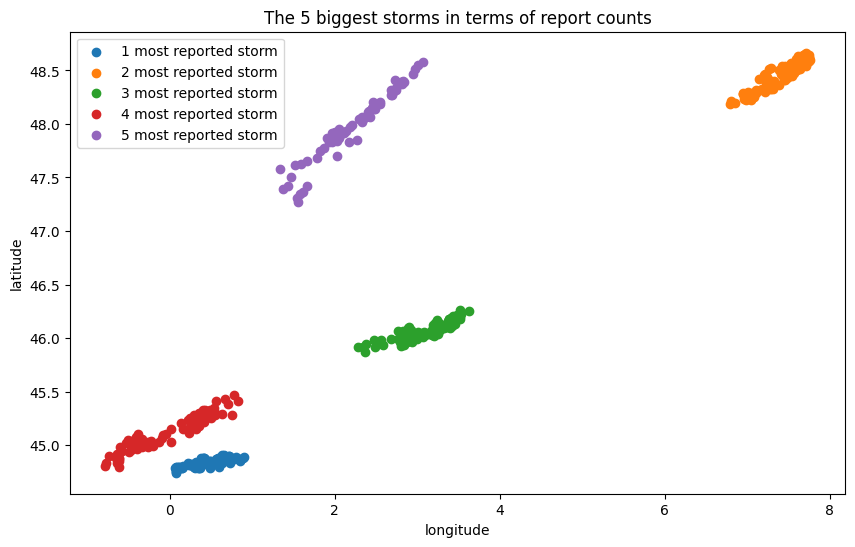

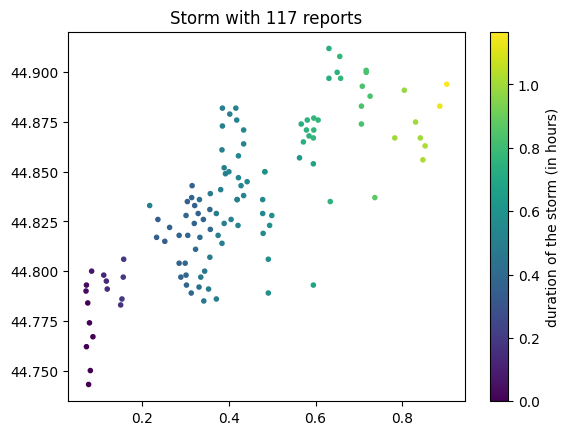

The storm has length 67.52959590342743 km between first report and last report
The storm took place on 2022-06-02 04:00:00


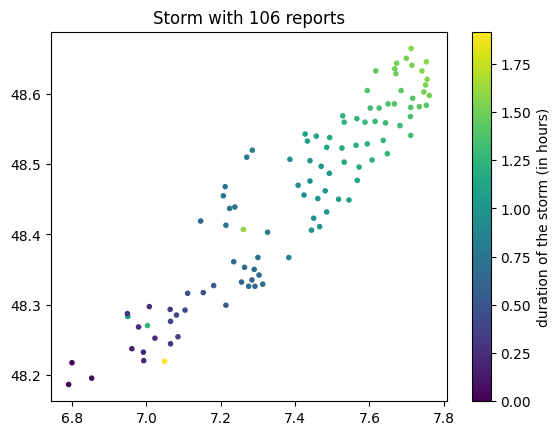

The storm has length 18.504621804533137 km between first report and last report
The storm took place on 2022-06-26 18:47:00


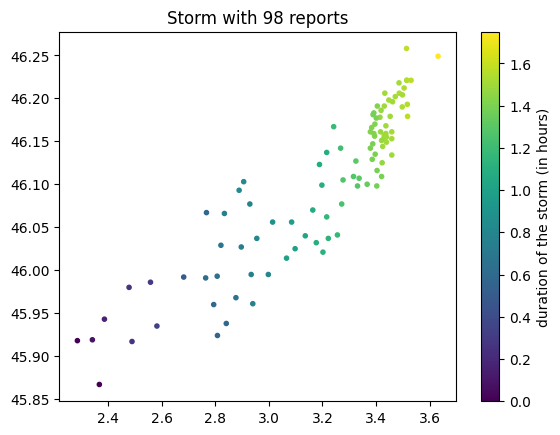

The storm has length 106.69913075712947 km between first report and last report
The storm took place on 2022-06-04 19:00:00


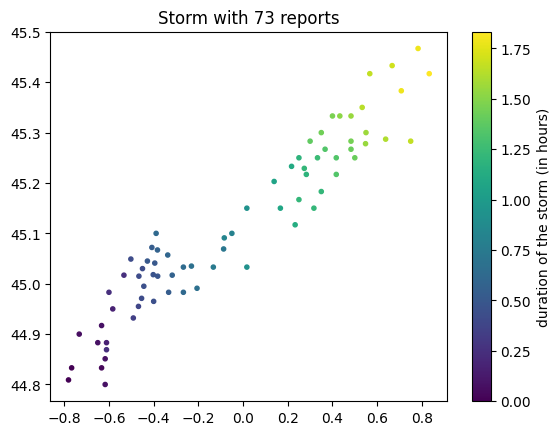

The storm has length 143.85972778583604 km between first report and last report
The storm took place on 2022-06-20 19:05:00


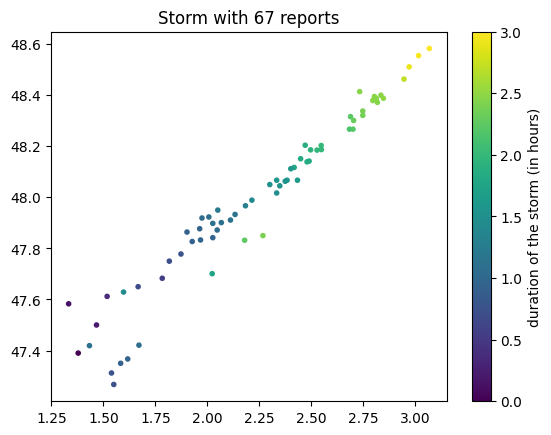

The storm has length 182.94462377735636 km between first report and last report
The storm took place on 2022-06-19 18:02:00
The percentage of reports in the bin is 10.491071428571429 %


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,181
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,-1
1978,458174.166667,48.636,4.952,-1


In [21]:
# inputting the spatial threshold, then the temporal, and the minimum number of observations per cluster

df1 = run_dbscan_retrieve_classes(df, 0.16, 1, 2)
visualise_biggest(df1,5)

In [13]:
df_date = convert_timestamps_to_date(df1)
df_date

,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,2022-10-24 10:15:00.000000000,45.567,5.933,0
1,2022-10-24 09:51:59.999999744,45.596,5.875,0
2,2022-10-23 16:30:00.000000000,49.583,1.358,1
3,2022-10-23 16:25:00.000000000,49.533,1.267,1
4,2022-10-23 16:23:00.000000256,49.521,1.251,1
...,...,...,...,...
1975,2022-04-23 11:40:00.000000000,43.279,2.460,181
1976,2022-04-22 18:30:00.000000000,44.600,-0.933,-1
1977,2022-04-08 14:17:00.000000000,48.669,5.114,-1
1978,2022-04-08 14:10:00.000000000,48.636,4.952,-1
